### Proyecto Final Capstone  -  Apertura hotel Buenos Aires

#### Parte 1 - Agrupacion de barrios por similitud Ciudad de Buenos Aires

In [1]:
# Instalamos e importamos las librerias necesarias

import requests
import pandas as pd
import lxml
import numpy as np
import json
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
print('Librerias importadas')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.52         |     pyhd8ed1ab_0          35 KB  conda-forge
    geopy-2.2.0                |     pyhd8ed1ab_0          67 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         102 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.52-pyhd8ed1ab_0
  geopy              conda-forge/noarch::geopy-2.2.0-pyhd8ed1ab_0



geographiclib-1.52   | 35 KB     | ##################################### | 100% 
geopy-2.2.0          | 67 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transa

In [2]:
# Importamos el CSV con los datos de los barrios de Ciudad de Buenos Aires

datos_BsAs = pd.read_csv('barriosba.csv')
                   

In [3]:
datos_BsAs.head()

,X,Y,barrio,comuna,perimetro,area
0,-58.451848,-34.587854,CHACARITA,15,7724.852955,3.115707e+06
1,-58.471566,-34.596383,PATERNAL,15,7087.513295,2.229829e+06
2,-58.441842,-34.598138,VILLA CRESPO,15,8131.857075,3.615978e+06
3,-58.489001,-34.605918,VILLA DEL PARQUE,11,7705.389797,3.399596e+06
4,-58.422469,-34.609819,ALMAGRO,5,8537.901368,4.050752e+06


In [4]:
# Eliminammos las columnas perimetro y area ya que no son utiles

datos_BsAs=datos_BsAs.drop(['perimetro','area'],axis=1)

In [5]:
# Renombramos Y , X , y ordenamos las columnas para una mejor visualizacion

datos_BsAs=datos_BsAs[['barrio','comuna','Y','X']]
datos_BsAs.columns=['barrio','comuna','Latitud','Longitud']
datos_BsAs.sort_values(by=['barrio'], ascending=True,inplace=True)
datos_BsAs.reset_index(drop=True, inplace=True)
datos_BsAs.head()

,barrio,comuna,Latitud,Longitud
0,AGRONOMIA,15,-34.592205,-58.488356
1,ALMAGRO,5,-34.609819,-58.422469
2,BALVANERA,3,-34.609334,-58.403267
3,BARRACAS,4,-34.644338,-58.382657
4,BELGRANO,13,-34.553347,-58.446548


In [6]:
# Revisamos tamaño Dataframe

datos_BsAs.shape

(48, 4)

In [7]:
# Obtenemos coordenadas para Capital Federal (Buenos Aires)

address = 'Capital Federal, AR'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Coordenadas Buenos Aires {}, {}.'.format(latitude, longitude))

Coordenadas Buenos Aires -34.6075682, -58.4370894.


In [8]:
# Creamos un mapa de la ciudad con marcadores para una primera visualizacion

In [9]:

map_BsAs = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, barrio, comuna in zip(datos_BsAs['Latitud'], datos_BsAs['Longitud'], datos_BsAs['barrio'],datos_BsAs['comuna']):
    label = '{}, {}'.format(barrio,comuna)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=30,
        parse_html=False).add_to(map_BsAs)  
    
map_BsAs

In [13]:
# Definimos version y credenciales para la API de Foursquare con un limite de 80 devoluciones

CLIENT_ID = 'Z4PDSMBCF1MP5WFJNLSCYQTYHVLCGQAYKMQYRYFCKLYTKKVR' 
CLIENT_SECRET = '0H2WBIQTBJDLBRDSLWSU1Q5PSRIXZLGH2YVXQFIQOGO0NTHC' 
VERSION = '20180605' 
LIMIT = 50

In [16]:
# Creamos la funcion para obtener los 50 sitios en un radio de 800 mts para cada barrio

def getNearbyVenues(names, latitudes, longitudes, radius=800):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # crear la URL de solicitud de API
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
                # solicitud GET
        results = requests.get(url).json()["response"]['groups'][0]['items']
             # regresa solo información relevante de cada sitio cercano
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['BARRIO', 
                  'BARRIO Latitude', 
                  'BARRIO Longitude', 
                  'LUGAR', 
                  'LUGAR Latitude', 
                  'LUGAR Longitude', 
                  'LUGAR Category']
    
    return(nearby_venues)
        

In [17]:
BsAs_lugares = getNearbyVenues(names=datos_BsAs['barrio'],
                                   latitudes=datos_BsAs['Latitud'],
                                   longitudes=datos_BsAs['Longitud'])

AGRONOMIA
ALMAGRO
BALVANERA
BARRACAS
BELGRANO
BOCA
BOEDO
CABALLITO
CHACARITA
COGHLAN
COLEGIALES
CONSTITUCION
FLORES
FLORESTA
LINIERS
MATADEROS
MONSERRAT
MONTE CASTRO
NUEVA POMPEYA
NUÑEZ
PALERMO
PARQUE AVELLANEDA
PARQUE CHACABUCO
PARQUE CHAS
PARQUE PATRICIOS
PATERNAL
PUERTO MADERO
RECOLETA
RETIRO
SAAVEDRA
SAN CRISTOBAL
SAN NICOLAS
SAN TELMO
VELEZ SARSFIELD
VERSALLES
VILLA CRESPO
VILLA DEL PARQUE
VILLA DEVOTO
VILLA GRAL. MITRE
VILLA LUGANO
VILLA LURO
VILLA ORTUZAR
VILLA PUEYRREDON
VILLA REAL
VILLA RIACHUELO
VILLA SANTA RITA
VILLA SOLDATI
VILLA URQUIZA


In [18]:
# Mostramos Dataframe

BsAs_lugares.head()

,BARRIO,BARRIO Latitude,BARRIO Longitude,LUGAR,LUGAR Latitude,LUGAR Longitude,LUGAR Category
0,AGRONOMIA,-34.592205,-58.488356,Club Comunicaciones,-34.596538,-58.490417,Sports Club
1,AGRONOMIA,-34.592205,-58.488356,Vivero Agronomía,-34.591700,-58.488838,Garden Center
2,AGRONOMIA,-34.592205,-58.488356,Feria del Productor al Consumidor,-34.593981,-58.483098,Farmers Market
3,AGRONOMIA,-34.592205,-58.488356,Dorian Café & Bar,-34.587906,-58.493465,Café
4,AGRONOMIA,-34.592205,-58.488356,Rayuela,-34.596635,-58.486246,Snack Place


In [19]:
# Observemos cuantos sitios se devolvieron por barrio

BsAs_lugares.groupby('BARRIO').count()

,BARRIO Latitude,BARRIO Longitude,LUGAR,LUGAR Latitude,LUGAR Longitude,LUGAR Category
BARRIO,,,,,,
AGRONOMIA,21,21,21,21,21,21
ALMAGRO,50,50,50,50,50,50
BALVANERA,50,50,50,50,50,50
BARRACAS,12,12,12,12,12,12
BELGRANO,50,50,50,50,50,50
BOCA,49,49,49,49,49,49
BOEDO,31,31,31,31,31,31
CABALLITO,50,50,50,50,50,50
CHACARITA,50,50,50,50,50,50


In [20]:
print('There are {} uniques categories.'.format(len(BsAs_lugares['LUGAR Category'].unique())))

There are 203 uniques categories.


In [21]:

# codificación
BsAs_onehot = pd.get_dummies(BsAs_lugares[['LUGAR Category']], prefix="", prefix_sep="")

# añadir la columna de barrio de regreso al dataframe
BsAs_onehot['BARRIO'] = BsAs_lugares['BARRIO'] 

# mover la columna de barrio a la primer columna
fixed_columns = [BsAs_onehot.columns[-1]] + list(BsAs_onehot.columns[:-1])
BsAs_onehot = BsAs_onehot[fixed_columns]

BsAs_onehot.shape

(1453, 204)

In [22]:
# Agrupamos las filas por barrios tomando el parametro de promedio de ocurrencia de cada categoria

BsAs_grouped = BsAs_onehot.groupby('BARRIO').mean().reset_index()
BsAs_grouped

,BARRIO,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,...,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Shop,Women's Store
0,AGRONOMIA,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.047619,...,0.047619,0.047619,0.0000,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000
1,ALMAGRO,0.00,0.00,0.140000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0000,0.020000,0.00,0.00,0.00,0.00,0.00,0.000000
2,BALVANERA,0.00,0.00,0.020000,0.000000,0.000000,0.040000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000
3,BARRACAS,0.00,0.00,0.166667,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000
4,BELGRANO,0.00,0.00,0.040000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0000,0.020000,0.00,0.00,0.00,0.00,0.00,0.000000
5,BOCA,0.00,0.00,0.285714,0.081633,0.040816,0.020408,0.000000,0.00000,0.020408,...,0.000000,0.000000,0.0000,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000
6,BOEDO,0.00,0.00,0.290323,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000
7,CABALLITO,0.00,0.00,0.060000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0000,0.020000,0.00,0.00,0.00,0.00,0.00,0.000000
8,CHACARITA,0.00,0.00,0.040000,0.000000,0.000000,0.000000,0.000000,0.02000,0.000000,...,0.000000,0.000000,0.0000,0.020000,0.02,0.00,0.00,0.02,0.00,0.000000
9,COGHLAN,0.00,0.00,0.156250,0.000000,0.000000,0.000000,0.000000,0.00000,0.031250,...,0.000000,0.031250,0.0000,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000


In [23]:
# Visualizamos cada barrio con los 10 lugares mas comunes

num_top_venues = 10

for hood in BsAs_grouped['BARRIO']:
    print("----"+hood+"----")
    temp = BsAs_grouped[BsAs_grouped['BARRIO'] == hood].T.reset_index()
    temp.columns = ['LUGAR','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----AGRONOMIA----
                  LUGAR  freq
0          Burger Joint  0.10
1           Pizza Place  0.10
2          Soccer Field  0.10
3              Bus Stop  0.05
4            Restaurant  0.05
5         Garden Center  0.05
6           Snack Place  0.05
7           Coffee Shop  0.05
8         Grocery Store  0.05
9  Gym / Fitness Center  0.05


----ALMAGRO----
                    LUGAR  freq
0  Argentinian Restaurant  0.14
1          Ice Cream Shop  0.12
2                    Café  0.08
3             Pizza Place  0.06
4                     Bar  0.04
5          Sandwich Place  0.04
6            Concert Hall  0.04
7                     Gym  0.04
8             Cheese Shop  0.04
9                   Hotel  0.04


----BALVANERA----
                  LUGAR  freq
0                  Café  0.14
1           Coffee Shop  0.06
2  Fast Food Restaurant  0.06
3           Pizza Place  0.06
4   Japanese Restaurant  0.06
5                   Gym  0.04
6             BBQ Joint  0.04
7                 Hote

In [24]:
# Creamos una funcion para ordenar en forma descendente los lugares

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
# mostramos los primeros 10 lugares de cada barrio en un Dataframe nuevo

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

In [26]:

columns = ['BARRIO']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# crear un nuevo dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['BARRIO'] = BsAs_grouped['BARRIO']

for ind in np.arange(BsAs_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(BsAs_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,BARRIO,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AGRONOMIA,Soccer Field,Burger Joint,Pizza Place,BBQ Joint,Bus Stop,Café,Sports Club,Grocery Store,Gym / Fitness Center,Snack Place
1,ALMAGRO,Argentinian Restaurant,Ice Cream Shop,Café,Pizza Place,Indie Theater,Cheese Shop,Sandwich Place,Gym,Concert Hall,Bar
2,BALVANERA,Café,Pizza Place,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Electronics Store,Bakery,Gym,Theater,BBQ Joint
3,BARRACAS,Argentinian Restaurant,Clothing Store,Electronics Store,General Entertainment,Auto Workshop,Gym,Restaurant,Sporting Goods Shop,Plaza,Soccer Field
4,BELGRANO,Italian Restaurant,BBQ Joint,Pizza Place,Café,Grocery Store,Coffee Shop,Cocktail Bar,Bistro,Supermarket,Sushi Restaurant


In [27]:


# establecer el número de agrupaciones en 4
kclusters = 4

BsAs_grouped_clustering = BsAs_grouped.drop('BARRIO', 1)

# ejecutar k-means
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(BsAs_grouped_clustering)

# revisar las etiquetas de las agrupaciones generadas para cada fila del dataframe
kmeans.labels_[0:4] 


array([0, 0, 3, 0], dtype=int32)

In [28]:
# añadir etiquetas
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

BsAs_merged = datos_BsAs

# juntar Toronto_grouped con Toronto_data 
BsAs_merged = BsAs_merged.join(neighborhoods_venues_sorted.set_index('BARRIO'), on='barrio')
BsAs_merged['Cluster Labels'] = BsAs_merged['Cluster Labels'].fillna("0").astype(int)

In [29]:
BsAs_merged.head() # revisar las ultimas columnas

,barrio,comuna,Latitud,Longitud,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AGRONOMIA,15,-34.592205,-58.488356,0,Soccer Field,Burger Joint,Pizza Place,BBQ Joint,Bus Stop,Café,Sports Club,Grocery Store,Gym / Fitness Center,Snack Place
1,ALMAGRO,5,-34.609819,-58.422469,0,Argentinian Restaurant,Ice Cream Shop,Café,Pizza Place,Indie Theater,Cheese Shop,Sandwich Place,Gym,Concert Hall,Bar
2,BALVANERA,3,-34.609334,-58.403267,3,Café,Pizza Place,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Electronics Store,Bakery,Gym,Theater,BBQ Joint
3,BARRACAS,4,-34.644338,-58.382657,0,Argentinian Restaurant,Clothing Store,Electronics Store,General Entertainment,Auto Workshop,Gym,Restaurant,Sporting Goods Shop,Plaza,Soccer Field
4,BELGRANO,13,-34.553347,-58.446548,3,Italian Restaurant,BBQ Joint,Pizza Place,Café,Grocery Store,Coffee Shop,Cocktail Bar,Bistro,Supermarket,Sushi Restaurant


In [30]:
# creamos mapa de agrupacion
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# establecer el esquema de color para las agrupaciones
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# añadir marcadores al mapa
markers_colors = []
for lat, lon, poi, cluster in zip(BsAs_merged['Latitud'], BsAs_merged['Longitud'], BsAs_merged['barrio'], BsAs_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

In [31]:
BsAs_group1=BsAs_merged.loc[BsAs_merged['Cluster Labels'] == 0, BsAs_merged.columns[[0] + list(range(5, BsAs_merged.shape[1]))]]
BsAs_group1

,barrio,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AGRONOMIA,Soccer Field,Burger Joint,Pizza Place,BBQ Joint,Bus Stop,Café,Sports Club,Grocery Store,Gym / Fitness Center,Snack Place
1,ALMAGRO,Argentinian Restaurant,Ice Cream Shop,Café,Pizza Place,Indie Theater,Cheese Shop,Sandwich Place,Gym,Concert Hall,Bar
3,BARRACAS,Argentinian Restaurant,Clothing Store,Electronics Store,General Entertainment,Auto Workshop,Gym,Restaurant,Sporting Goods Shop,Plaza,Soccer Field
5,BOCA,Argentinian Restaurant,Art Gallery,Café,BBQ Joint,Pizza Place,Art Museum,Seafood Restaurant,Restaurant,Coffee Shop,Gift Shop
6,BOEDO,Argentinian Restaurant,Bakery,Pizza Place,Soccer Field,Pharmacy,Burger Joint,Cheese Shop,Brewery,Breakfast Spot,Stadium
9,COGHLAN,Argentinian Restaurant,Pizza Place,BBQ Joint,Plaza,Gym / Fitness Center,Ice Cream Shop,Bakery,Brewery,Supermarket,Event Space
11,CONSTITUCION,Café,Soccer Field,German Restaurant,Pizza Place,Ice Cream Shop,Residential Building (Apartment / Condo),Metro Station,Bakery,Restaurant,BBQ Joint
12,FLORES,Pharmacy,Café,Ice Cream Shop,Pizza Place,Coffee Shop,Bakery,Gym,Dessert Shop,Department Store,Empanada Restaurant
13,FLORESTA,Argentinian Restaurant,Deli / Bodega,Café,Ice Cream Shop,Restaurant,Sandwich Place,Bus Stop,Middle Eastern Restaurant,Gym,Pharmacy
14,LINIERS,Argentinian Restaurant,Plaza,Gym / Fitness Center,Burger Joint,Ice Cream Shop,Grocery Store,Bus Stop,Mobile Phone Shop,Pizza Place,BBQ Joint


In [32]:
BsAs_group2=BsAs_merged.loc[BsAs_merged['Cluster Labels'] == 1, BsAs_merged.columns[[0] + list(range(5, BsAs_merged.shape[1]))]]
BsAs_group2

,barrio,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,VILLA RIACHUELO,Racetrack,Furniture / Home Store,Go Kart Track,Gas Station,Garden,Fried Chicken Joint,French Restaurant,Food Truck,Food Service,Food & Drink Shop


In [33]:
BsAs_group3=BsAs_merged.loc[BsAs_merged['Cluster Labels'] == 2, BsAs_merged.columns[[0] + list(range(5, BsAs_merged.shape[1]))]]
BsAs_group3

,barrio,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
46,VILLA SOLDATI,Bus Stop,Soccer Stadium,Light Rail Station,Women's Store,Fish Market,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Service


In [34]:
BsAs_group4=BsAs_merged.loc[BsAs_merged['Cluster Labels'] == 3, BsAs_merged.columns[[0] + list(range(5, BsAs_merged.shape[1]))]]
BsAs_group4

,barrio,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,BALVANERA,Café,Pizza Place,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Electronics Store,Bakery,Gym,Theater,BBQ Joint
4,BELGRANO,Italian Restaurant,BBQ Joint,Pizza Place,Café,Grocery Store,Coffee Shop,Cocktail Bar,Bistro,Supermarket,Sushi Restaurant
7,CABALLITO,Café,Ice Cream Shop,Gym,Argentinian Restaurant,Bakery,Pizza Place,Burger Joint,Soccer Stadium,Coffee Shop,Restaurant
8,CHACARITA,Café,Pizza Place,Restaurant,Ice Cream Shop,Office,Sandwich Place,Tapas Restaurant,Bakery,Theater,Bar
10,COLEGIALES,Argentinian Restaurant,Coffee Shop,Pizza Place,Brewery,Beer Bar,Restaurant,Café,Bakery,Cheese Shop,Spa
16,MONSERRAT,Café,Argentinian Restaurant,Hostel,Hotel,Spanish Restaurant,Coffee Shop,BBQ Joint,Theater,Burger Joint,Nightclub
19,NUÑEZ,Restaurant,BBQ Joint,Soccer Field,Gym,Sports Club,Argentinian Restaurant,Indoor Play Area,Sushi Restaurant,History Museum,Harbor / Marina
20,PALERMO,Deli / Bodega,Ice Cream Shop,Bakery,Bistro,Plaza,Gym / Fitness Center,Beer Bar,Gym,Italian Restaurant,Creperie
26,PUERTO MADERO,Food Truck,BBQ Joint,Trail,Nature Preserve,Burger Joint,Outdoor Sculpture,Restaurant,Art Museum,Museum,Furniture / Home Store
27,RECOLETA,Hotel,Italian Restaurant,Park,Plaza,Café,Ice Cream Shop,Argentinian Restaurant,Art Museum,Bakery,Lounge


#### Parte 2 - Comparacion de barrios de el grupo elegido 

In [35]:
# Elegimos al grupo BsAs_group4 dada su afinidad en cuanto a lugares de esparcimiento
# Revisamos tamaño

BsAs_group4.shape

(17, 11)

In [36]:
# Renombramos y generamos el nuevo dataframe para su estudio

In [37]:
BsAs_group4=BsAs_group4['barrio']


In [38]:
BsAs_hotel=pd.merge(BsAs_group4,datos_BsAs)

In [39]:
BsAs_hotel

,barrio,comuna,Latitud,Longitud
0,BALVANERA,3,-34.609334,-58.403267
1,BELGRANO,13,-34.553347,-58.446548
2,CABALLITO,6,-34.616874,-58.443459
3,CHACARITA,15,-34.587854,-58.451848
4,COLEGIALES,13,-34.574762,-58.453232
5,MONSERRAT,1,-34.612308,-58.379440
6,NUÑEZ,13,-34.542706,-58.461128
7,PALERMO,14,-34.574274,-58.422710
8,PUERTO MADERO,1,-34.609976,-58.352688
9,RECOLETA,2,-34.584019,-58.393354


In [40]:
# Revisamos tamaño 

BsAs_hotel.shape

(17, 4)

In [41]:
# Importamos el CSV con los datos de gastronomia de Ciudad de Buenos Aires

food_BsAs = pd.read_csv('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/oferta-gastronomica/oferta_gastronomica.csv')

In [42]:
food_BsAs

,long,lat,id,nombre,categoria,cocina,ambientacion,telefono,mail,horario,calle_nombre,calle_altura,calle_cruce,direccion_completa,barrio,comuna,codigo_postal,codigo_postal_argentino
0,-58.363307,-34.622963,1602,GUANTANAMERA,RESTAURANTE,CUBANA,MODERNO,4314 0770,NaN,NaN,MOREAU DE JUSTO ALICIA,2092,NaN,"MOREAU DE JUSTO, ALICIA AV. 2092",Puerto Madero,Comuna 1,1107.0,C1107AFP
1,-58.392330,-34.621554,676,1843 VINACOTECA,VINERIA,NaN,NaN,4779 0806,NaN,lunes a domingo de 8 a 00,HUMBERTO 1º,1843,NaN,HUMBERTO 1º 1843,San Cristobal,Comuna 3,NaN,NaN
2,-58.453542,-34.560311,487,2080 EXPRESS,RESTAURANTE,TRADICIONAL,CLASICO PORTEÑO,4788 4500,NaN,lunes a domingo de 8 a 00,JURAMENTO,2080,NaN,JURAMENTO AV. 2080,Belgrano,Comuna 13,1428.0,C1428DNH
3,-58.475491,-34.677051,2737,22,CAFE,MINUTAS,MODERNO,NaN,NaN,NaN,MURGUIONDO,4188,NaN,MURGUIONDO 4188,Villa Lugano,Comuna 8,1439.0,C1439FTB
4,-58.425437,-34.585695,2,4 EN 2 I,RESTAURANTE,NaN,NaN,4832 9510,NaN,NaN,BORGES JORGE LUIS,2095,NaN,"BORGES, JORGE LUIS 2095",Palermo,Comuna 14,1425.0,C1425FFA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,-58.401107,-34.599643,893,ZOE PIZZA & CAFE,RESTAURANTE,PORTEÃ‘A,MODERNO,4961 8378,NaN,NaN,AZCUENAGA,796,NaN,AZCUENAGA 796,Balvanera,Comuna 3,1029.0,C1029AAP
2819,-58.386372,-34.607178,2546,ZOMBI,RESTAURANTE,MINUTAS,MODERNO,4371 6964,NaN,lunes a viernes de 8 a 00,URUGUAY,142,NaN,URUGUAY 142,San Nicolas,Comuna 1,1015.0,C1015ABD
2820,-58.463108,-34.543369,1521,ZONA,RESTAURANTE,INTERNACIONAL,RUSTICA,4704 5018,www.zonapizza.com,NaN,11 DE SEPTIEMBRE DE 1888,3900,NaN,11 DE SEPTIEMBRE DE 1888 3900,NuÃƒÂ±ez,Comuna 13,1429.0,C1429BIV
2821,-58.395697,-34.602213,894,ZOO BAR,RESTAURANTE,MINUTAS,MODERNO,4374 4879,NaN,NaN,TUCUMAN,2002,NaN,TUCUMAN 2002,Balvanera,Comuna 3,1050.0,C1050AAP


In [43]:
# Organizamos el Dataframe con los campos que nos interesan

food_BsAs=food_BsAs[['categoria','cocina','barrio','comuna']]

In [44]:
food_BsAs

,categoria,cocina,barrio,comuna
0,RESTAURANTE,CUBANA,Puerto Madero,Comuna 1
1,VINERIA,NaN,San Cristobal,Comuna 3
2,RESTAURANTE,TRADICIONAL,Belgrano,Comuna 13
3,CAFE,MINUTAS,Villa Lugano,Comuna 8
4,RESTAURANTE,NaN,Palermo,Comuna 14
...,...,...,...,...
2818,RESTAURANTE,PORTEÃ‘A,Balvanera,Comuna 3
2819,RESTAURANTE,MINUTAS,San Nicolas,Comuna 1
2820,RESTAURANTE,INTERNACIONAL,NuÃƒÂ±ez,Comuna 13
2821,RESTAURANTE,MINUTAS,Balvanera,Comuna 3


In [45]:
food_BsAs.loc[food_BsAs['barrio'].str.contains('±ez'), 'barrio'] = 'Nuñez'

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
food_BsAs.head()

,categoria,cocina,barrio,comuna
0,RESTAURANTE,CUBANA,Puerto Madero,Comuna 1
1,VINERIA,NaN,San Cristobal,Comuna 3
2,RESTAURANTE,TRADICIONAL,Belgrano,Comuna 13
3,CAFE,MINUTAS,Villa Lugano,Comuna 8
4,RESTAURANTE,NaN,Palermo,Comuna 14


In [47]:
# Revisamos si hay columnas con valores NaN

food_BsAs.isnull().any()

categoria     True
cocina        True
barrio       False
comuna       False
dtype: bool

In [48]:
# Como hay valores nulos en las columnas Categoria y Cocina , vamos a reemplazarlos por la ocurrencia mayor en cada caso


In [49]:
#Primero encontramos la mayor ocurrencia para 'Cocina'

cocinaprom=food_BsAs.groupby('cocina') ,food_BsAs['cocina'].value_counts(normalize=True)

In [50]:
cocinaprom

(<pandas.core.groupby.generic.DataFrameGroupBy object at 0x7fc7f8e6ca20>,
 MINUTAS             0.299107
 INTERNACIONAL       0.181818
 TRADICIONAL         0.120536
 PIZZERIA            0.071429
 PARRILLA            0.064529
 SANDWICHERIA        0.051542
 FAST FOOD           0.032873
 ITALIANA            0.031250
 MEDITERRANEA        0.019481
 PORTEÃ‘A            0.015828
 DE AUTOR            0.012987
 REGIONAL            0.012175
 ESPAÃ‘OLA           0.010146
 CHINA               0.006899
 SUSHI               0.004870
 TENEDOR LIBRE       0.004464
 JAPONESA            0.004058
 AMERICANA           0.003653
 FRANCESA            0.003247
 FUSION              0.003247
 TAPAS               0.003247
 MODERNO             0.002841
 MARISCOS            0.002841
 NATURISTA           0.002841
 MEXICANA            0.002841
 BOLIVIANA           0.002435
 ARABE               0.002435
 CUBANA              0.002435
 ARMENIA             0.002435
 GOURMET             0.002029
 VEGETARIANA         0.001

In [51]:
# Reemplazamos los nulos de 'Cocina' por la mayor ocurrencia :'MINUTAS'

food_BsAs["cocina"].fillna("MINUTAS", inplace = True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [52]:
food_BsAs.head()

,categoria,cocina,barrio,comuna
0,RESTAURANTE,CUBANA,Puerto Madero,Comuna 1
1,VINERIA,MINUTAS,San Cristobal,Comuna 3
2,RESTAURANTE,TRADICIONAL,Belgrano,Comuna 13
3,CAFE,MINUTAS,Villa Lugano,Comuna 8
4,RESTAURANTE,MINUTAS,Palermo,Comuna 14


In [53]:
#Luego encontramos la mayor ocurrencia para 'categoria'

categoriaprom=food_BsAs.groupby('categoria') ,food_BsAs['categoria'].value_counts(normalize=True)

In [54]:
categoriaprom

(<pandas.core.groupby.generic.DataFrameGroupBy object at 0x7fc7f9aab630>,
 RESTAURANTE             0.735131
 CAFE                    0.123384
 BAR                     0.091245
 CONFITERIA              0.020318
 PUB                     0.019579
 VINERIA                 0.008127
 SANDWICHERIA            0.001478
 DELIVERY & TAKE AWAY    0.000739
 Name: categoria, dtype: float64)

In [55]:
# Reemplazamos los nulos de 'categoria' por la mayor ocurrencia :'RESTAURANTE'

food_BsAs["categoria"].fillna("RESTAURANTE", inplace = True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [56]:
# Comprobamos que no queden valores nulos

food_BsAs.isnull().any()

categoria    False
cocina       False
barrio       False
comuna       False
dtype: bool

In [57]:
# Ahora calculamos cuantos locales gastronomicos hay por barrio

food_BsAsg=food_BsAs.groupby('barrio').size().to_frame('cantidad')
food_BsAsg.reset_index(inplace=True)
food_BsAsg.head()

,barrio,cantidad
0,Agronomia,3
1,Almagro,63
2,Balvanera,215
3,Barracas,49
4,Belgrano,71


In [58]:
# Ordenamos y mostramos los primeros 10 barrios

food_BsAsg=food_BsAsg.sort_values(by='cantidad',ascending=False)
food_BsAsg.head()
food_BsAsg=food_BsAsg.iloc[0:10]
food_BsAsg

,barrio,cantidad
20,Palermo,467
30,San Nicolas,454
26,Recoleta,327
2,Balvanera,215
16,Monserrat,149
7,Caballito,125
27,Retiro,109
12,Flores,85
31,San Telmo,80
4,Belgrano,71


In [59]:
# Importamos libreria Seaborn y visualizamos

import seaborn as sns

<AxesSubplot:xlabel='barrio', ylabel='cantidad'>

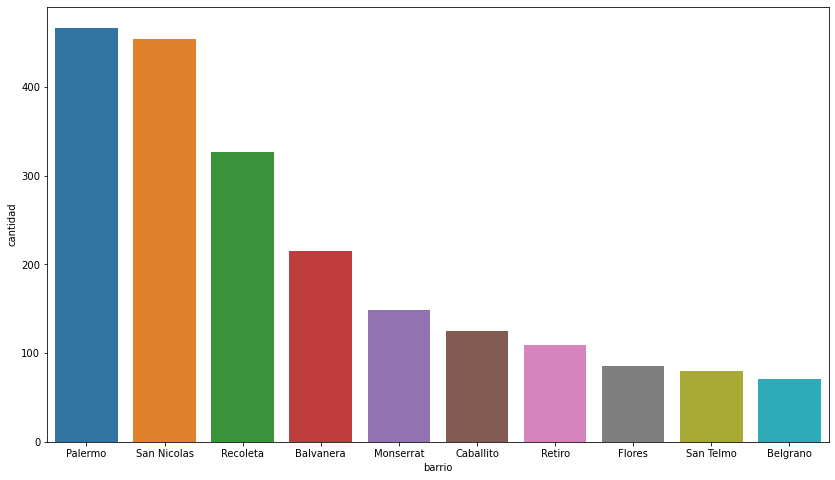

In [60]:
	

plt.figure(figsize = (14,8))
sns.barplot(x = 'barrio', y = 'cantidad', 
           data = food_BsAsg)

In [61]:
# Realizamos el proceso anterior para los tipos de cocina

cfood_BsAs=food_BsAs.groupby(['cocina','barrio']).size().to_frame('count')
cfood_BsAs.reset_index(inplace=True)
cfood_BsAs.head()

,cocina,barrio,count
0,AFRODISIACA,Palermo,1
1,ALEMANA,Barracas,1
2,ALEMANA,Palermo,1
3,ALEMANA,San Nicolas,1
4,AMERICANA,Nuñez,1


In [62]:
ccfood_BsAs=cfood_BsAs.groupby(['count','barrio']).size().to_frame('Variedad')
ccfood_BsAs.reset_index(inplace=True)
ccfood_BsAs.head()

,count,barrio,Variedad
0,1,Agronomia,3
1,1,Almagro,7
2,1,Balvanera,7
3,1,Barracas,1
4,1,Belgrano,4


In [63]:
# Ordenamos y mostramos los primeros 10 barrios

ccfood_BsAs=ccfood_BsAs.sort_values(by='Variedad',ascending=False)
ccfood_BsAs.head()
ccfood_BsAs=ccfood_BsAs.iloc[0:10]
ccfood_BsAs

,count,barrio,Variedad
28,1,San Nicolas,12
19,1,Palermo,10
24,1,Recoleta,9
7,1,Caballito,9
23,1,Puerto Madero,8
25,1,Retiro,8
2,1,Balvanera,7
1,1,Almagro,7
32,1,Villa Crespo,7
29,1,San Telmo,6


<AxesSubplot:xlabel='barrio', ylabel='Variedad'>

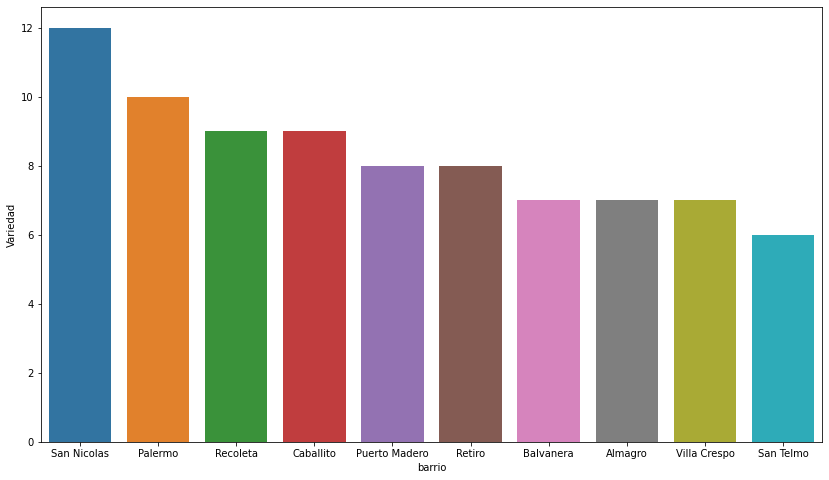

In [64]:
# Visualizamos

plt.figure(figsize = (14,8))
sns.barplot(x = 'barrio', y = 'Variedad', 
           data = ccfood_BsAs)

In [65]:
BsAs=BsAs_hotel[['barrio','comuna','Latitud','Longitud']]

In [66]:
BsAs.head()

,barrio,comuna,Latitud,Longitud
0,BALVANERA,3,-34.609334,-58.403267
1,BELGRANO,13,-34.553347,-58.446548
2,CABALLITO,6,-34.616874,-58.443459
3,CHACARITA,15,-34.587854,-58.451848
4,COLEGIALES,13,-34.574762,-58.453232


In [67]:
# Creamos una funcion para consultar a Foursquare lugares especificos por la id proporcionada por Foursquare para cada 
# categoria por barrio en un radio de 800 mts

LIMIT=50
def Lugares(names, latitudes, longitudes, radius=800,categoryId=''):
    restaurant_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        if(categoryId!=''):
            url=url+'&categoryId={}'
            url=url.format(categoryId)
                    # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # retrun only the venue name, corrdinates and catagoery
        restaurant_list.append([(
            name, 
            #lat, 
            #lng, 
            v['venue']['name'], 
            #v['venue']['location']['lat'], 
            #v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_entertainment = pd.DataFrame([item for restaurant_list in restaurant_list for item in restaurant_list])
    nearby_entertainment.columns = ['Barrio', 
                  #'Neighborhood Latitude', 
                  #'Neighborhood Longitude', 
                  'Nombre', 
                  #'restaurant Latitude', 
                  #'restaurant Longitude', 
                  'Categoria']
    
    return(nearby_entertainment)          

In [68]:
# Consultamos Museos,Teatros,Cines,Parques y Centros comerciales utilizando la funcion antes creada

In [69]:
Museos=Lugares(names=BsAs_hotel['barrio'], latitudes=BsAs_hotel['Latitud'], longitudes=BsAs_hotel['Longitud'], radius=1000, categoryId='4bf58dd8d48988d181941735')

In [70]:
Parques=Lugares(names=BsAs_hotel['barrio'], latitudes=BsAs_hotel['Latitud'], longitudes=BsAs_hotel['Longitud'], radius=1000, categoryId='4bf58dd8d48988d163941735')

In [71]:
Cines=Lugares(names=BsAs_hotel['barrio'], latitudes=BsAs_hotel['Latitud'], longitudes=BsAs_hotel['Longitud'], radius=1000, categoryId='4bf58dd8d48988d17f941735')

In [72]:
Teatros=Lugares(names=BsAs_hotel['barrio'], latitudes=BsAs_hotel['Latitud'], longitudes=BsAs_hotel['Longitud'], radius=1000, categoryId='4bf58dd8d48988d137941735')

In [73]:
Shoppings=Lugares(names=BsAs_hotel['barrio'], latitudes=BsAs_hotel['Latitud'], longitudes=BsAs_hotel['Longitud'], radius=1000, categoryId='4bf58dd8d48988d1fd941735')

In [74]:
# Agrupamos y ordenamos los 10 primeros barrios

In [75]:
Museos_BsAs=Museos.groupby(['Nombre','Barrio']).size().to_frame('count')
Museos_BsAs.reset_index(inplace=True)


In [76]:
Museos_BsAs=Museos_BsAs.groupby(['count','Barrio']).size().to_frame('Museos')
Museos_BsAs.reset_index(inplace=True)


In [77]:
Museos_BsAs=Museos_BsAs.sort_values(by='Museos',ascending=False)
Museos_BsAs.head()
Museos_BsAs=Museos_BsAs.iloc[0:10]
Museos_BsAs

,count,Barrio,Museos
4,1,MONSERRAT,11
8,1,RECOLETA,10
10,1,SAN NICOLAS,8
9,1,RETIRO,6
11,1,SAN TELMO,6
0,1,BALVANERA,3
1,1,BELGRANO,3
5,1,NUÑEZ,3
2,1,CABALLITO,2
6,1,PALERMO,2


In [78]:
# Visualizamos

<AxesSubplot:xlabel='Barrio', ylabel='Museos'>

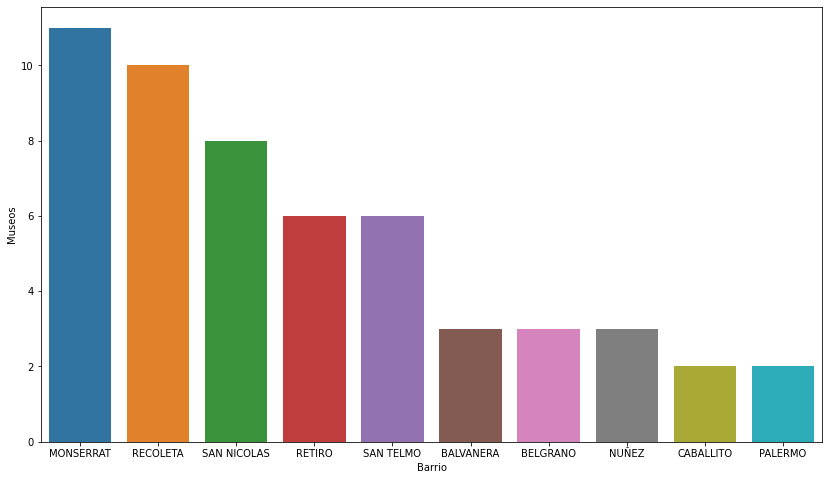

In [79]:
plt.figure(figsize = (14,8))
sns.barplot(x = 'Barrio', y = 'Museos', 
           data = Museos_BsAs)

In [80]:
# Repetimos la operacion para las categorias restantes

In [81]:
Parques_BsAs=Parques.groupby(['Nombre','Barrio']).size().to_frame('count')
Parques_BsAs.reset_index(inplace=True)

In [82]:
Parques_BsAs=Parques_BsAs.groupby(['count','Barrio']).size().to_frame('Parques')
Parques_BsAs.reset_index(inplace=True)

In [83]:
Parques_BsAs=Parques_BsAs.sort_values(by='Parques',ascending=False)
Parques_BsAs.head()
Parques_BsAs=Parques_BsAs.iloc[0:10]
Parques_BsAs

,count,Barrio,Parques
8,1,RECOLETA,11
6,1,PALERMO,5
7,1,PUERTO MADERO,5
1,1,BELGRANO,4
3,1,CHACARITA,3
4,1,COLEGIALES,3
9,1,RETIRO,3
11,1,SAN TELMO,3
12,1,VILLA CRESPO,3
0,1,BALVANERA,2


<AxesSubplot:xlabel='Barrio', ylabel='Parques'>

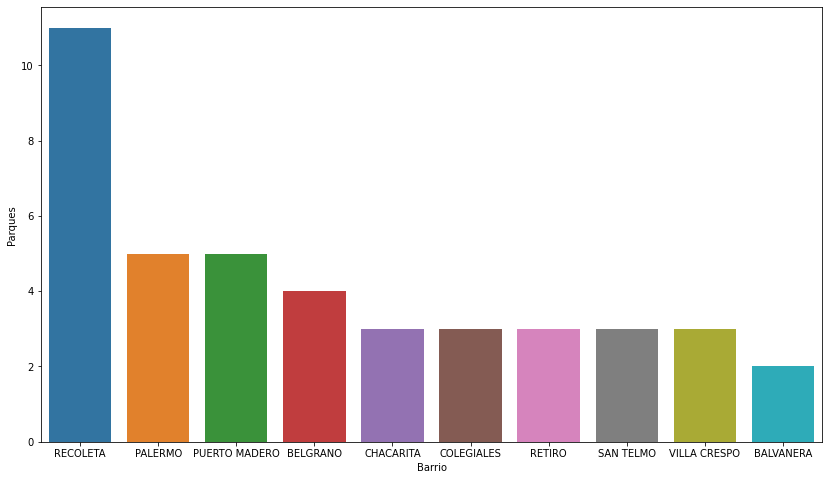

In [84]:
plt.figure(figsize = (14,8))
sns.barplot(x = 'Barrio', y = 'Parques', 
           data = Parques_BsAs)

In [85]:
Cines_BsAs=Cines.groupby(['Nombre','Barrio']).size().to_frame('count')
Cines_BsAs.reset_index(inplace=True)


In [86]:
Cines_BsAs=Cines_BsAs.groupby(['count','Barrio']).size().to_frame('Cines')
Cines_BsAs.reset_index(inplace=True)
Cines_BsAs.head(10)

,count,Barrio,Cines
0,1,BALVANERA,5
1,1,BELGRANO,2
2,1,CABALLITO,1
3,1,CHACARITA,4
4,1,COLEGIALES,3
5,1,MONSERRAT,2
6,1,PALERMO,3
7,1,PUERTO MADERO,1
8,1,RECOLETA,3
9,1,SAN NICOLAS,8


In [87]:
Cines_BsAs=Cines_BsAs.sort_values(by='Cines',ascending=False)
Cines_BsAs.head()
Cines_BsAs=Cines_BsAs.iloc[0:10]
Cines_BsAs

,count,Barrio,Cines
9,1,SAN NICOLAS,8
0,1,BALVANERA,5
11,1,VILLA CRESPO,5
3,1,CHACARITA,4
4,1,COLEGIALES,3
6,1,PALERMO,3
8,1,RECOLETA,3
1,1,BELGRANO,2
5,1,MONSERRAT,2
10,1,SAN TELMO,2


<AxesSubplot:xlabel='Barrio', ylabel='Cines'>

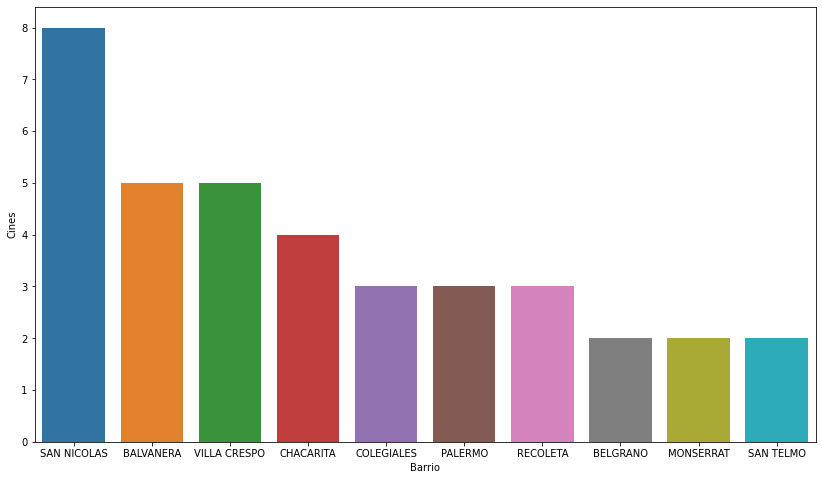

In [88]:
plt.figure(figsize = (14,8))
sns.barplot(x = 'Barrio', y = 'Cines', 
           data = Cines_BsAs)

In [89]:
Teatros_BsAs=Teatros.groupby(['Nombre','Barrio']).size().to_frame('count')
Teatros_BsAs.reset_index(inplace=True)

In [90]:
Teatros_BsAs=Teatros_BsAs.groupby(['count','Barrio']).size().to_frame('Teatros')
Teatros_BsAs.reset_index(inplace=True)
Teatros_BsAs.head(10)

,count,Barrio,Teatros
0,1,BALVANERA,11
1,1,BELGRANO,1
2,1,CABALLITO,1
3,1,CHACARITA,4
4,1,COLEGIALES,2
5,1,MONSERRAT,20
6,1,PALERMO,3
7,1,PUERTO MADERO,1
8,1,RECOLETA,3
9,1,RETIRO,2


In [91]:
Teatros_BsAs=Teatros_BsAs.sort_values(by='Teatros',ascending=False)
Teatros_BsAs.head()
Teatros_BsAs=Teatros_BsAs.iloc[0:10]
Teatros_BsAs

,count,Barrio,Teatros
10,1,SAN NICOLAS,43
5,1,MONSERRAT,20
0,1,BALVANERA,11
11,1,SAN TELMO,6
12,1,VILLA CRESPO,5
3,1,CHACARITA,4
6,1,PALERMO,3
8,1,RECOLETA,3
4,1,COLEGIALES,2
9,1,RETIRO,2


<AxesSubplot:xlabel='Barrio', ylabel='Teatros'>

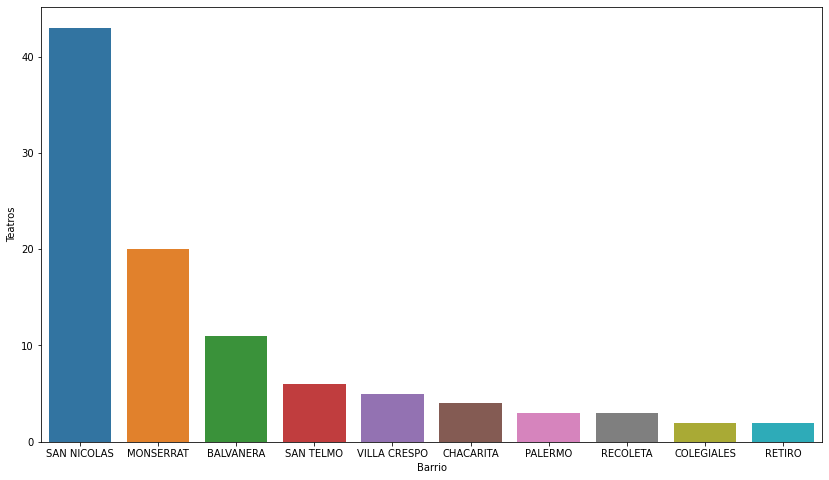

In [92]:
plt.figure(figsize = (14,8))
sns.barplot(x = 'Barrio', y = 'Teatros', 
           data = Teatros_BsAs)

In [93]:
Shoppings_BsAs=Shoppings.groupby(['Nombre','Barrio']).size().to_frame('count')
Shoppings_BsAs.reset_index(inplace=True)
Shoppings_BsAs

,Nombre,Barrio,count
0,Abasto Shopping,BALVANERA,1
1,Arcos del Gourmet,PALERMO,1
2,Arcos del Gourmet,VILLA DEVOTO,1
3,Bled,VILLA ORTUZAR,1
4,Caballito Shopping Center,CABALLITO,1
5,Carrefour Expres,VILLA URQUIZA,1
6,Closure,CHACARITA,1
7,Closure,VILLA CRESPO,1
8,Coto,SAN TELMO,1
9,Distrito Arcos,PALERMO,1


In [94]:
Shoppings_BsAs=Shoppings_BsAs.groupby(['count','Barrio']).size().to_frame('Shoppings')
Shoppings_BsAs.reset_index(inplace=True)


In [95]:
Shoppings_BsAs=Shoppings_BsAs.sort_values(by='Shoppings',ascending=False)
Shoppings_BsAs.head()
Shoppings_BsAs=Shoppings_BsAs.iloc[0:10]
Shoppings_BsAs

,count,Barrio,Shoppings
10,1,SAN NICOLAS,7
2,1,CABALLITO,5
12,1,VILLA CRESPO,5
0,1,BALVANERA,4
3,1,CHACARITA,4
7,1,PALERMO,4
4,1,COLEGIALES,3
5,1,MONSERRAT,3
8,1,RECOLETA,3
13,1,VILLA DEVOTO,3


<AxesSubplot:xlabel='Barrio', ylabel='Shoppings'>

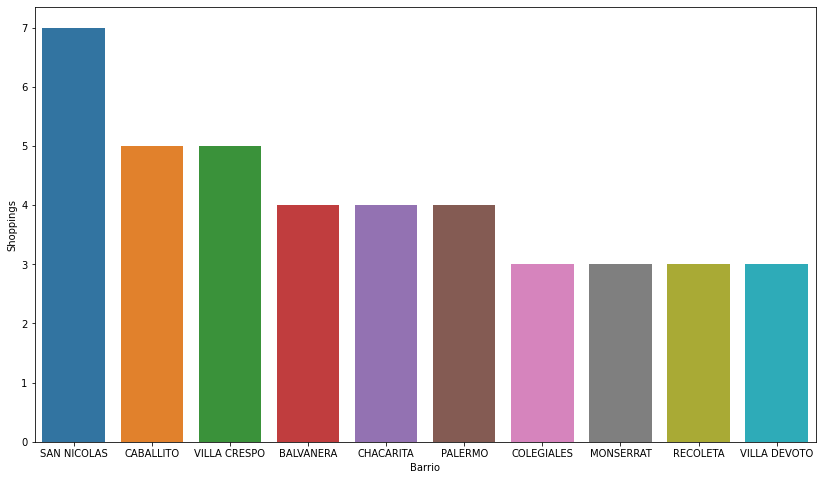

In [96]:
plt.figure(figsize = (14,8))
sns.barplot(x = 'Barrio', y = 'Shoppings', 
           data = Shoppings_BsAs)

#### Parte 3 - Datos mercado inmobiliario

In [97]:
# Obtenemos los datos del Gobierno de la Ciudad para el sector inmobiliario por barrio

In [187]:
inmobiliario=pd.read_csv('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/acceso-vivienda-y-mercado-inmobiliario/precio-venta-deptos.csv')

In [188]:
# Descartamos las columnas innecesarias

inmob_BsAs=inmobiliario[['barrio','año','precio_prom','estado']]

In [189]:
# Revisamos tamaño

inmob_BsAs.shape

(7296, 4)

In [190]:
# Filtramos para trabajar con los años 2017-2019 , excluyendo los valores nulos y solo con deptos a estrenar

inmob_BsAs=inmob_BsAs[inmob_BsAs.año.isin([2017,2019]) & inmob_BsAs.precio_prom.notnull()]
inmob_BsAs=inmob_BsAs[inmob_BsAs.estado=='A estrer']

In [191]:
# Revisamos tamaño

inmob_BsAs.shape

(215, 4)

In [192]:
# Integramos con el grupo de barrios seleccionado anteriormente

inmob_BsAs=pd.merge(BsAs_group4,inmob_BsAs)

In [193]:
# Revisamos tamaño

inmob_BsAs.shape

(117, 4)

In [194]:
inmob_BsAs.head()

,barrio,año,precio_prom,estado
0,BALVANERA,2017,1992.0,A estrer
1,BALVANERA,2017,2072.0,A estrer
2,BALVANERA,2017,2227.0,A estrer
3,BALVANERA,2017,2268.0,A estrer
4,BALVANERA,2019,2544.0,A estrer


In [195]:
# Agrupamos por barrio , y por año promedio para 2017 - 2019

df=inmob_BsAs.groupby(['barrio','año'], as_index=False).precio_prom.mean()

In [196]:
df.head()

,barrio,año,precio_prom
0,BALVANERA,2017,2221.625
1,BALVANERA,2019,2720.000
2,BELGRANO,2017,3702.750
3,BELGRANO,2019,4139.250
4,CABALLITO,2017,2947.625


In [197]:
# Descartamos barrios con info insuficiente

df = df.drop(df[df['barrio']=='VILLA GRAL. MITRE'].index)
df = df.drop(df[df['barrio']=='VILLA DEVOTO'].index)
df = df.drop(df[df['barrio']=='SAN TELMO'].index)
df = df.drop(df[df['barrio']=='PUERTO MADERO'].index)
df = df.drop(df[df['barrio']=='PARQUE CHAS'].index)
df = df.drop(df[df['barrio']=='MONSERRAT'].index)
df = df.drop(df[df['barrio']=='MATADEROS'].index)
df = df.drop(df[df['barrio']=='CHACARITA'].index)




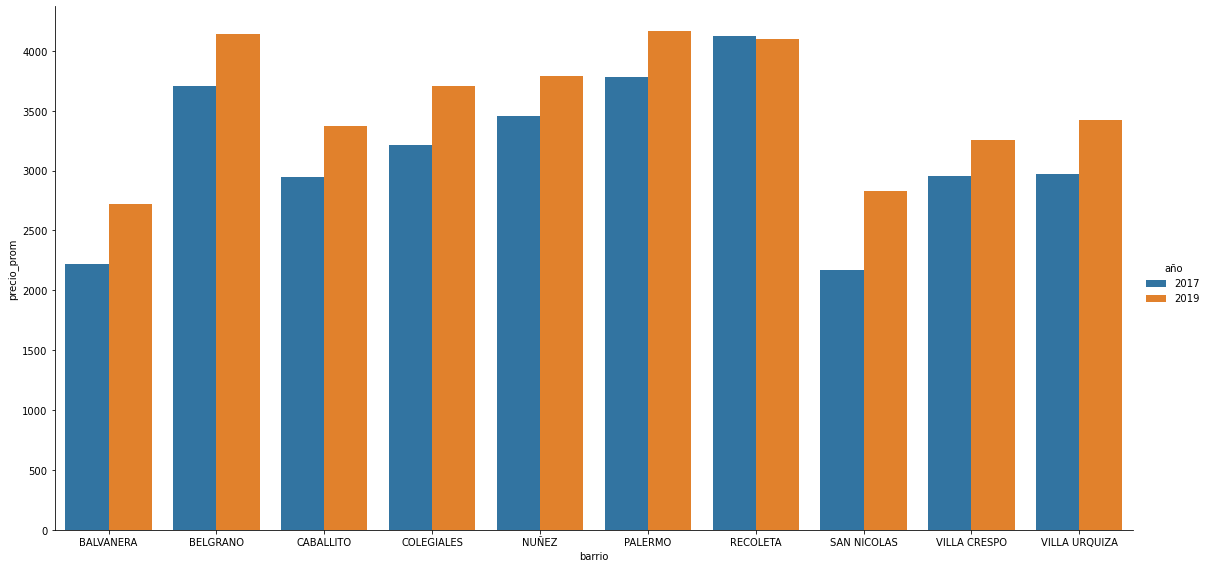

In [198]:
# Visualizamos los precios por barrio para 2017-2019

splot=sns.catplot(x='barrio', y='precio_prom', hue='año', data=df, kind='bar',height=8, aspect=2),


In [199]:
# Reorganizamos para calcular el porcentaje de aumento de 2017 a 2019

In [200]:
df1 = df[df['año'] == 2017]

In [201]:
df2 = df[df['año'] == 2019]

In [202]:
df2.rename(columns={'año':'2019','precio_prom':'prec2019'},inplace=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [203]:
df1.rename(columns={'año': '2017','precio_prom':'prec2017'},inplace=True)

In [204]:
bs=pd.merge (df1,df2)

In [205]:
p=(bs['prec2019']-bs['prec2017'])/bs['prec2017']*100

In [206]:
bs.loc[:,'porcentaje'] = p

In [207]:

bs.drop(axis=1, columns='2017',inplace=True)

        

In [208]:
bs.drop(axis=1, columns='2019',inplace=True)

In [209]:
bsaas=pd.merge(bs,df)

In [210]:
bsaas.head()

,barrio,prec2017,prec2019,porcentaje,año,precio_prom
0,BALVANERA,2221.625,2720.00,22.432904,2017,2221.625
1,BALVANERA,2221.625,2720.00,22.432904,2019,2720.000
2,BELGRANO,3702.750,4139.25,11.788536,2017,3702.750
3,BELGRANO,3702.750,4139.25,11.788536,2019,4139.250
4,CABALLITO,2947.625,3373.00,14.431110,2017,2947.625


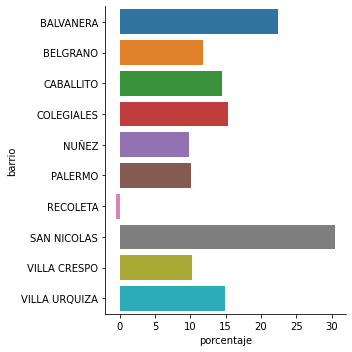

In [211]:
  
# Visualizamos la variacion en porcentaje de precios por barrio

g = sns.catplot(x="porcentaje", 
                y="barrio", 
                kind="bar", 
                data=bsaas)

#### Parte 4 - Densidad de hoteles 4 estrellas por barrio

In [ ]:
# Obtenemos los datos de los hoteles y categorias para la ciudad

In [146]:
dfgg1 = pd.read_excel(io = "_alojamientos_registrados_ENTUR_20200110 (3).xlsx",sheet_name='Table 11',names=['Cat','Nombre','Dir','Barrio','Tel'])

In [147]:
dfgg2=pd.read_excel(io = "_alojamientos_registrados_ENTUR_20200110 (3).xlsx",sheet_name='Table 13',names=['Cat','Nombre','Dir','Barrio','Tel'])

In [148]:
dfgg3=pd.read_excel(io = "_alojamientos_registrados_ENTUR_20200110 (3).xlsx",sheet_name='Table 15',names=['Cat','Nombre','Dir','Barrio','Tel'])

In [ ]:
# Fusionamos los archivos excel , limpiamos de datos innecesarios y normalizamos

In [149]:
cat=pd.concat([dfgg1, dfgg2, dfgg3], axis=0)

In [150]:
cat.reset_index(drop=True, inplace=True)

In [151]:
cat=cat.drop(['Dir','Tel'],axis=1)

In [152]:
cat.replace({'SAN NICOLÁS' : 'SAN NICOLAS'},inplace=True)

In [153]:
cat.head()

,Cat,Nombre,Barrio
0,3*,REGIS HOTEL,SAN NICOLAS
1,3*,BABEL PLAZA (ex-RIVER HOTEL),SAN NICOLAS
2,3*,ROCHESTER CONCEPT (ex HYDE PARK),SAN NICOLAS
3,3*,SARMIENTO PALACE HOTEL,BALVANERA
4,3*,SARUM,BELGRANO


In [154]:
# Filtramos por hoteles 4 estrellas , ordenamos y obtenemos cantidad por barrio

indexNames = cat[ cat['Cat'] != '4*' ].index

In [155]:
cat.drop(indexNames , inplace=True)

In [157]:
cat=cat.groupby(['Barrio']).size().reset_index(name='Cantidad')

In [212]:
cat.head()

,Barrio,Cantidad
0,BALVANERA,1
1,MONSERRAT,4
2,PALERMO,1
3,PUERTO MADERO,1
4,RECOLETA,5


In [159]:
# Generamos un mapa de la Ciudad 

address = 'Capital Federal, AR'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Coordenadas Buenos Aires {}, {}.'.format(latitude, longitude))

Coordenadas Buenos Aires -34.6075682, -58.4370894.


In [160]:
map_BsAs = folium.Map(location=[latitude, longitude], zoom_start=11)

In [161]:
# Generamos un mapa coropletico con la densidad de hoteles 4 estrellas 
map_BsAs.choropleth(
    geo_data=BsAs_geo,
    data=cat,
    columns=['Barrio', 'Cantidad'],
    key_on='properties.barrio',
    fill_color='YlOrRd', 
    fill_opacity=1.3, 
    line_opacity=0.5,
    legend_name='Densidad Hoteles 4 estrellas'
)
folium.LayerControl().add_to(map_BsAs)
map_BsAs
# muestre el mapa